<a href="https://colab.research.google.com/github/cfong32/key-sentence-extraction/blob/main/exp5_tfidf_cossim_rouge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q datasets rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.8 MB/s eta 0:00:00


In [4]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset
from spacy.lang.en import English
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score.rouge_scorer import RougeScorer
from itertools import cycle
from textwrap import wrap
from IPython.display import HTML as html_print
pd.set_option('display.min_rows', 4)
tqdm.pandas()

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Calculate TF-IDF Cosine-similarity (to the article) and ROUGE (to the highlights) on the CNN/DM Dataset

In [3]:
# load dataset into a dataframe

DATASET = 'cnn_dailymail'
CONFIG  = '3.0.0'
SUBSET  = 'test'

dataset = load_dataset(DATASET, CONFIG, split=SUBSET)
df = pd.DataFrame(dataset)
df

,article,highlights,id
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef
...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6


In [4]:
# split articles into sentences
# every entry of df['sentences'] will contain a list of strings

spacy_eng_nlp = English()
spacy_eng_nlp.add_pipe("sentencizer")

df['sentences'] = df.progress_apply(
    lambda x: (
        [str(s) for s in spacy_eng_nlp(x.article).sents]
    ),
    axis=1
)
df

100%|██████████| 11490/11490 [01:00<00:00, 190.95it/s]


,article,highlights,id,sentences
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st..."
...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,..."
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...


In [5]:
# calculate TF-IDF (Term Frequency-Inverse Document Frequency)
# then calculate the cosine-similarity of each sentence to the "article"
# every entry of df['tfidf_cossim'] will be an ndarray indicating cossim of the sentences

articles = df.article.tolist()
tfidf = TfidfVectorizer().fit(articles)

df['tfidf_cossim'] = df.progress_apply(
    lambda x: (
        cosine_similarity(
            tfidf.transform([x.article]),
            tfidf.transform(x.sentences)
        )[0]
    ),
    axis=1
)
df

100%|██████████| 11490/11490 [01:18<00:00, 145.94it/s]


,article,highlights,id,sentences,tfidf_cossim
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...,"[0.394838255251771, 0.2184224416188325, 0.5160..."
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st...","[0.0910601549035593, 0.29696905043672805, 0.43..."
...,...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,...","[0.3847239488347531, 0.20526128662452667, 0.59..."
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...,"[0.6310895042459086, 0.3007128522327899, 0.187..."


In [ ]:
# the following ROUGE calculation could take several minutes to run
# to save time, you may download the pre-calculated df by uncommenting the following two line
# !wget -O exp5.230221.2056.dfpkl https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/EUY6QIzDNCpDhL5APkm1vrUBZT3gWPOvT6ZCw21U0xh_Ow?download=1
# df = pd.read_pickle('exp5.230221.2056.dfpkl')

In [36]:
# calculate ROUGE score (Recall-Oriented Understudy for Gisting Evaluation)
# to the "highlights"
# every entry of df['Rouge'] will be an ndarray, which is the average of ROUGE-1, ROUGE-2 and ROUGE-L

rouge = RougeScorer(['rouge1', 'rouge2', 'rougeL'])

df['raw_rouge'] = df.progress_apply(
    lambda x: (
        [rouge.score(x.highlights, sentence)
         for sentence in x.sentences]
    ),
    axis=1
)
df['R1'] = df.raw_rouge.map(lambda xs: np.array([x['rouge1'].fmeasure for x in xs]))
df['R2'] = df.raw_rouge.map(lambda xs: np.array([x['rouge2'].fmeasure for x in xs]))
df['RL'] = df.raw_rouge.map(lambda xs: np.array([x['rougeL'].fmeasure for x in xs]))
df['Rouge'] = (df['R1'] + df['R2'] + df['RL']) / 3

df

100%|██████████| 11490/11490 [07:01<00:00, 27.29it/s]


,article,highlights,id,sentences,tfidf_cossim,raw_rouge,R1,R2,RL,Rouge
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...,"[0.394838255251771, 0.2184224416188325, 0.5160...","[{'rouge1': (0.41379310344827586, 0.3529411764...","[0.38095238095238093, 0.18867924528301885, 0.3...","[0.19672131147540986, 0.0, 0.1846153846153846,...","[0.28571428571428575, 0.1509433962264151, 0.32...","[0.2877959927140255, 0.11320754716981131, 0.30..."
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st...","[0.0910601549035593, 0.29696905043672805, 0.43...","[{'rouge1': (0.0, 0.0, 0.0), 'rouge2': (0.0, 0...","[0.0, 0.3720930232558139, 0.2191780821917808, ...","[0.0, 0.19047619047619047, 0.05633802816901408...","[0.0, 0.32558139534883723, 0.136986301369863, ...","[0.0, 0.29605020302694723, 0.1375008039102193,..."
...,...,...,...,...,...,...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,...","[0.3847239488347531, 0.20526128662452667, 0.59...","[{'rouge1': (0.21739130434782608, 0.15625, 0.1...","[0.18181818181818182, 0.14285714285714288, 0.3...","[0.0, 0.037037037037037035, 0.2702702702702703...","[0.14545454545454545, 0.14285714285714288, 0.3...","[0.10909090909090909, 0.10758377425044093, 0.3..."
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...,"[0.6310895042459086, 0.3007128522327899, 0.187...","[{'rouge1': (0.6129032258064516, 0.21590909090...","[0.31932773109243695, 0.16949152542372878, 0.2...","[0.17094017094017092, 0.0, 0.03418803418803419...","[0.2352941176470588, 0.11864406779661019, 0.11...","[0.24185400655988887, 0.096045197740113, 0.117..."


# Analyze Results

## Check correltations

In [90]:
# rank sentences within each article

def cal_ranking(x):
    return np.argsort(np.argsort(x)) / (len(x)-1)

df['rank_by_tfidf'] = df.tfidf_cossim.map(cal_ranking)
df['rank_by_Rouge'] = df.Rouge.map(cal_ranking)

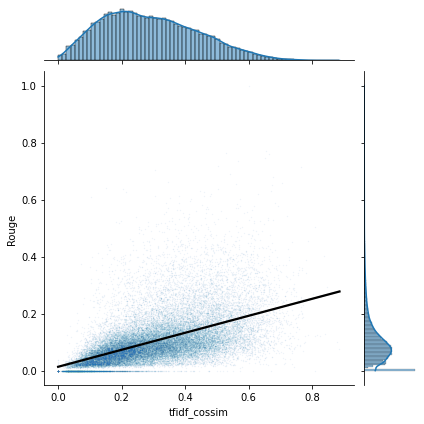

In [26]:
# plot tfidf_cossim vs Rouge

data = pd.DataFrame({
    'tfidf_cossim': df.tfidf_cossim.agg(np.concatenate),
    'Rouge'       : df.Rouge.agg(np.concatenate),
})
sns.jointplot(
    data=data.sample(frac=0.1),
    x='tfidf_cossim',
    y='Rouge',
    kind='reg',
    scatter_kws={'alpha': 0.1,
                 's'    : 0.1},    # dot size
    line_kws={'color': 'black'},
)
plt.show()

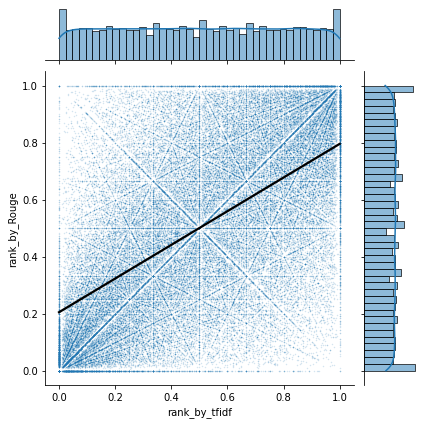

In [93]:
# plot rank, tfidf_cossim vs Rouge

data = pd.DataFrame({
    'rank_by_tfidf': df.rank_by_tfidf.agg(np.concatenate),
    'rank_by_Rouge': df.rank_by_Rouge.agg(np.concatenate),
})
sns.jointplot(
    data=data.sample(frac=0.2),
    x='rank_by_tfidf',
    y='rank_by_Rouge',
    kind='reg',
    scatter_kws={'alpha': 0.2,
                 's'    : 0.2},    # dot size
    line_kws={'color': 'black'},
)
plt.show()

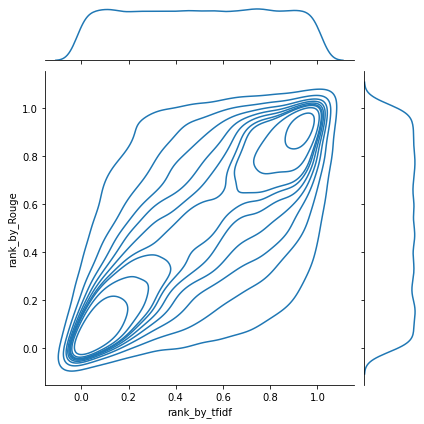

In [95]:
sns.jointplot(
    data=data.sample(frac=0.1),
    x='rank_by_tfidf',
    y='rank_by_Rouge',
    kind='kde',
)
plt.show()

## Show example by example

In [143]:
# sample one article, re-run to sample another

x = df.sample(1).iloc[0]
x

article          A convicted sex offender was reportedly run ov...
highlights       James Oliver, 48, was left with a serious leg ...
id                        ff6b74e05edd416604a9289bb9ba470b045a860d
sentences        [A convicted sex offender was reportedly run o...
tfidf_cossim     [0.33407582757486165, 0.6034709373170485, 0.41...
raw_rouge        [{'rouge1': (0.36363636363636365, 0.1230769230...
R1               [0.18390804597701152, 0.5057471264367815, 0.32...
R2               [0.023529411764705882, 0.49411764705882355, 0....
RL               [0.09195402298850576, 0.5057471264367815, 0.32...
Rouge            [0.09979716024340772, 0.5018706333107955, 0.30...
rank_by_tfidf    [0.15384615384615385, 0.7692307692307693, 0.23...
rank_by_Rouge    [0.15384615384615385, 1.0, 0.6153846153846154,...
Name: 1184, dtype: object

In [144]:
# show the rank of the scores

SHOW_ABOVE = 0.75
HIGHLIGHT_ABOVE = 0.9

data = pd.DataFrame({
    'rank_by_tfidf': x.rank_by_tfidf.round(2),
    'rank_by_Rouge': x.rank_by_Rouge.round(2),
    'sentence'     : x.sentences,
})

(data
 .query(f'rank_by_tfidf>{SHOW_ABOVE} or rank_by_Rouge>{SHOW_ABOVE}')
 .style
 .highlight_between(left=HIGHLIGHT_ABOVE,
                    color='yellow',
                    subset=['rank_by_tfidf'])
 .highlight_between(left=HIGHLIGHT_ABOVE,
                    color='#FF8888',
                    subset=['rank_by_Rouge'])
 .set_properties(**{'text-align': 'left'})
)

,rank_by_tfidf,rank_by_Rouge,sentence
1,0.770000,1.000000,"James Oliver, 48, was left with a serious leg injury after being allegedly hit by a car driven by Linda Currier, 53."
3,0.850000,0.770000,"James Oliver, 48, (left) was allegedly hit by a car driven by Linda Currier, 53 (right) who caught him allegedly trying to sexually assault a young girl ."
5,1.000000,0.380000,The dispute moved outside the home and then Currier allegedly hit Oliver with the car - he was taken to hospital.
8,0.920000,0.310000,The dispute moved outside the home and then Currier allegedly hit Oliver with the car (pictured) - he was taken to hospital .
10,0.620000,0.850000,"Oliver was arrested on his release from hospital and charged with attempted gross sexual assault, unlawful sexual touching and failing to comply with the sex offender registration act for not updating his address ."
11,0.690000,0.920000,"Oliver was arrested on his release from hospital and charged with attempted gross sexual assault, unlawful sexual touching and failing to comply with the sex offender registration act for not updating his address."


In [145]:
# show the text

html_str = ''
for rank_t, rank_r, sent in zip(x.rank_by_tfidf, x.rank_by_Rouge, x.sentences):
    if (rank_t > HIGHLIGHT_ABOVE and rank_r > HIGHLIGHT_ABOVE):
        html_str += f'<span style="background-color:yellow;color:#FF2222">{sent} </span>'
    elif (rank_t > HIGHLIGHT_ABOVE):
        html_str += f'<span style=background-color:yellow>{sent} </span>'
    elif (rank_r > HIGHLIGHT_ABOVE):
        html_str += f'<span style=background-color:#FF8888>{sent} </span>'
    else:
        html_str += f'{sent} '

html_print(html_str)